<a href="https://colab.research.google.com/github/Epatsili2000/ParkinsonDetection/blob/main/cnn_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Parkinson’s Detection Using CNN on Mel-Spectrograms**

This notebook trains a ResNet18 CNN to classify speech-based spectrograms as Parkinson’s Disease (PD) or Healthy Control (HC).


*1.*Dataset: Loaded from mel spectrogram metadata (mel_metadata_augmented.csv)**

*2.*Transforms: Image augmentations (resize, flip, affine) and normalization**

*3.*Split: StratifiedGroupKFold (no speaker overlap between train/val)**

*4.*Sampler: Weighted to balance PD/HC in training**

*5.*Loss: Focal Loss to handle class imbalance**

*6.*Model: Fine-tuned pretrained ResNet18**

*7.*Training: Includes learning rate scheduler and early stopping**

*8.*Evaluation: Classification report, ROC AUC, and confusion matrix plotted**

Model is saved if validation accuracy improves.

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Validation: 100%|██████████| 365/365 [43:38<00:00,  7.17s/it]


Epoch 1: Val Acc: 0.4773
✅ Best model saved!


Validation: 100%|██████████| 365/365 [00:46<00:00,  7.78it/s]


Epoch 2: Val Acc: 0.4623


Validation: 100%|██████████| 365/365 [00:46<00:00,  7.85it/s]


Epoch 3: Val Acc: 0.4792
✅ Best model saved!


Validation: 100%|██████████| 365/365 [00:46<00:00,  7.88it/s]


Epoch 4: Val Acc: 0.4905
✅ Best model saved!


Validation: 100%|██████████| 365/365 [00:46<00:00,  7.81it/s]


Epoch 5: Val Acc: 0.4786


Validation: 100%|██████████| 365/365 [00:46<00:00,  7.85it/s]


Epoch 6: Val Acc: 0.4850


Validation: 100%|██████████| 365/365 [00:46<00:00,  7.91it/s]


Epoch 7: Val Acc: 0.4850


Validation: 100%|██████████| 365/365 [00:46<00:00,  7.78it/s]


Epoch 8: Val Acc: 0.4839


Validation: 100%|██████████| 365/365 [00:46<00:00,  7.85it/s]


Epoch 9: Val Acc: 0.4821
⏹️ Early stopping triggered.

Classification Report:
              precision    recall  f1-score   support

          HC       1.00      0.42      0.60     10482
          PD       0.16      0.99      0.28      1191

    accuracy                           0.48     11673
   macro avg       0.58      0.71      0.44     11673
weighted avg       0.91      0.48      0.56     11673

ROC AUC: 0.7072


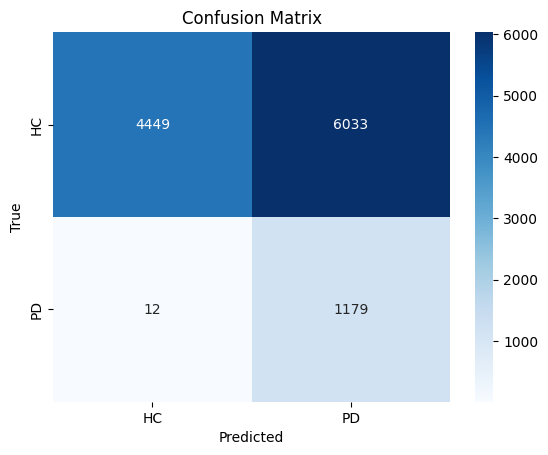

In [ ]:
# -------------------- SETUP --------------------
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms, models
from PIL import Image
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# === CONFIG ===
CSV_PATH = "/content/drive/MyDrive/PCGITA_RESULTS/mel_metadata_augmented.csv"
BATCH_SIZE = 32
IMG_SIZE = 224
NUM_EPOCHS = 30
NUM_CLASSES = 2
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_SAVE_PATH = "/content/drive/MyDrive/PCGITA_MODELS/best_cnn_mel_advanced.pth"

# -------------------- DATASET --------------------
class SpectrogramDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image = Image.open(row["filename"]).convert("RGB")
        label = 1 if row["label"] == "PD" else 0

        if self.transform:
            image = self.transform(image)

        return image, label

# -------------------- TRANSFORMS --------------------
transform_train = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(degrees=5, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

transform_val = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

# -------------------- DATA SPLIT --------------------
df = pd.read_csv(CSV_PATH)
df = df[df["label"].isin(["PD", "HC"])]

group_kfold = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)
splits = list(group_kfold.split(df, df["label"], groups=df["speaker_id"]))
train_idx, val_idx = splits[0]
df_train = df.iloc[train_idx].reset_index(drop=True)
df_val = df.iloc[val_idx].reset_index(drop=True)

train_dataset = SpectrogramDataset(df_train, transform=transform_train)
val_dataset = SpectrogramDataset(df_val, transform=transform_val)

# -------------------- WEIGHTED SAMPLER --------------------
sample_weights = df_train["label"].map({"PD": 1.0, "HC": 0.3}).values
sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# -------------------- FOCAL LOSS --------------------
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.ce = nn.CrossEntropyLoss(reduction='none')

    def forward(self, inputs, targets):
        ce_loss = self.ce(inputs, targets)
        pt = torch.exp(-ce_loss)
        if self.alpha is not None:
            at = self.alpha[targets]
            ce_loss = at * ce_loss
        loss = ((1 - pt) ** self.gamma) * ce_loss
        return loss.mean()

# Compute class weights
class_counts = df_train['label'].value_counts()
pos_weight = class_counts['HC'] / class_counts['PD']
alpha = torch.tensor([1.0, pos_weight]).to(DEVICE)

# -------------------- MODEL --------------------
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES)
model = model.to(DEVICE)

criterion = FocalLoss(alpha=alpha, gamma=2.0)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

# -------------------- EARLY STOPPING --------------------
class EarlyStopping:
    def __init__(self, patience=5):
        self.patience = patience
        self.counter = 0
        self.best_loss = np.inf
        self.early_stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

early_stopper = EarlyStopping(patience=5)

# -------------------- TRAIN LOOP --------------------
train_losses, val_losses = [], []
best_val_acc = 0

for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss = 0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} - Training"):
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_losses.append(running_loss / len(train_loader))

    # Validation
    model.eval()
    val_loss = 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc="Validation"):
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    scheduler.step(val_loss)

    acc = np.mean(np.array(all_preds) == np.array(all_labels))
    print(f"Epoch {epoch+1}: Val Acc: {acc:.4f}")

    if acc > best_val_acc:
        best_val_acc = acc
        torch.save(model.state_dict(), MODEL_SAVE_PATH)
        print("✅ Best model saved!")

    early_stopper(val_loss)
    if early_stopper.early_stop:
        print("⏹️ Early stopping triggered.")
        break

# -------------------- EVALUATION --------------------
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=["HC", "PD"]))

auc = roc_auc_score(all_labels, all_preds)
print(f"ROC AUC: {auc:.4f}")

cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["HC", "PD"], yticklabels=["HC", "PD"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

#**CNN** Model (ResNet34) for Parkinson's Detection from Mel-**Spectrograms**

This section trains a deep CNN model (ResNet34) to classify Parkinson’s Disease (PD) from speech-derived mel-spectrogram images.

1. Input: Spectrograms from mel_metadata_augmented.csv

2. Preprocessing: Image augmentations (crop, jitter, flip, affine), normalization

3. Splitting: StratifiedGroupKFold to ensure no speaker overlap across folds

4. Sampling: Weighted sampling to handle class imbalance

5. Loss: Focal Loss with class weights to focus on hard samples

6. Model: Pretrained ResNet34 with custom final layer

7. Training: Early stopping, learning rate scheduling, model checkpointing

8. Evaluation: Prints classification report, ROC AUC, and shows confusion matrix

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 190MB/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Validation: 100%|██████████| 365/365 [00:47<00:00,  7.71it/s]


Epoch 1: Val Acc: 0.4761
✅ Best model saved!


Validation: 100%|██████████| 365/365 [00:47<00:00,  7.68it/s]


Epoch 2: Val Acc: 0.4572


Validation: 100%|██████████| 365/365 [00:47<00:00,  7.67it/s]


Epoch 3: Val Acc: 0.4682


Validation: 100%|██████████| 365/365 [00:47<00:00,  7.72it/s]


Epoch 4: Val Acc: 0.4793
✅ Best model saved!


Validation: 100%|██████████| 365/365 [00:47<00:00,  7.67it/s]


Epoch 5: Val Acc: 0.4821
✅ Best model saved!


Validation: 100%|██████████| 365/365 [00:47<00:00,  7.62it/s]


Epoch 6: Val Acc: 0.4629


Validation: 100%|██████████| 365/365 [00:47<00:00,  7.70it/s]


Epoch 7: Val Acc: 0.4823
✅ Best model saved!


Validation: 100%|██████████| 365/365 [00:47<00:00,  7.68it/s]


Epoch 8: Val Acc: 0.4740


Validation: 100%|██████████| 365/365 [00:47<00:00,  7.67it/s]


Epoch 9: Val Acc: 0.4797
⏹️ Early stopping triggered.

Classification Report:
              precision    recall  f1-score   support

          HC       1.00      0.42      0.59     10482
          PD       0.16      0.99      0.28      1191

    accuracy                           0.48     11673
   macro avg       0.58      0.71      0.44     11673
weighted avg       0.91      0.48      0.56     11673

ROC AUC: 0.7058


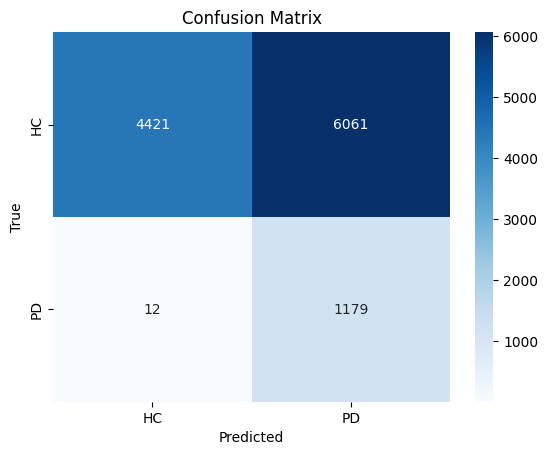

In [ ]:
# -------------------- SETUP --------------------
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms, models
from PIL import Image
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# === CONFIG ===
CSV_PATH = "/content/drive/MyDrive/PCGITA_RESULTS/mel_metadata_augmented.csv"
BATCH_SIZE = 32
IMG_SIZE = 224
NUM_EPOCHS = 30
NUM_CLASSES = 2
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_SAVE_PATH = "/content/drive/MyDrive/PCGITA_MODELS/best_cnn_resnet34_mel.pth"

# -------------------- DATASET --------------------
class SpectrogramDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image = Image.open(row["filename"]).convert("RGB")
        label = 1 if row["label"] == "PD" else 0

        if self.transform:
            image = self.transform(image)

        return image, label

# -------------------- TRANSFORMS --------------------
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0)),
    transforms.RandomApply([transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2)], p=0.5),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

transform_val = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

# -------------------- DATA SPLIT --------------------
df = pd.read_csv(CSV_PATH)
df = df[df["label"].isin(["PD", "HC"])]

# Cross-task GroupKFold: Combine label and task to ensure cross-task consistency
df["group_label"] = df["label"] + "_" + df["task"]
group_kfold = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)
splits = list(group_kfold.split(df, df["label"], groups=df["speaker_id"]))
train_idx, val_idx = splits[0]
df_train = df.iloc[train_idx].reset_index(drop=True)
df_val = df.iloc[val_idx].reset_index(drop=True)

train_dataset = SpectrogramDataset(df_train, transform=transform_train)
val_dataset = SpectrogramDataset(df_val, transform=transform_val)

# -------------------- WEIGHTED SAMPLER --------------------
sample_weights = df_train["label"].map({"PD": 1.0, "HC": 0.3}).values
sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# -------------------- FOCAL LOSS --------------------
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.ce = nn.CrossEntropyLoss(reduction='none')

    def forward(self, inputs, targets):
        ce_loss = self.ce(inputs, targets)
        pt = torch.exp(-ce_loss)
        if self.alpha is not None:
            at = self.alpha[targets]
            ce_loss = at * ce_loss
        loss = ((1 - pt) ** self.gamma) * ce_loss
        return loss.mean()

# Compute class weights
class_counts = df_train['label'].value_counts()
pos_weight = class_counts['HC'] / class_counts['PD']
alpha = torch.tensor([1.0, pos_weight]).to(DEVICE)

# -------------------- MODEL --------------------
model = models.resnet34(weights=models.ResNet34_Weights.DEFAULT)
model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES)
model = model.to(DEVICE)

criterion = FocalLoss(alpha=alpha, gamma=2.0)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

# -------------------- EARLY STOPPING --------------------
class EarlyStopping:
    def __init__(self, patience=5):
        self.patience = patience
        self.counter = 0
        self.best_loss = np.inf
        self.early_stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

early_stopper = EarlyStopping(patience=5)

# -------------------- TRAIN LOOP --------------------
train_losses, val_losses = [], []
best_val_acc = 0

for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss = 0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} - Training"):
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_losses.append(running_loss / len(train_loader))

    # Validation
    model.eval()
    val_loss = 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc="Validation"):
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    scheduler.step(val_loss)

    acc = np.mean(np.array(all_preds) == np.array(all_labels))
    print(f"Epoch {epoch+1}: Val Acc: {acc:.4f}")

    if acc > best_val_acc:
        best_val_acc = acc
        torch.save(model.state_dict(), MODEL_SAVE_PATH)
        print("✅ Best model saved!")

    early_stopper(val_loss)
    if early_stopper.early_stop:
        print("⏹️ Early stopping triggered.")
        break

# -------------------- EVALUATION --------------------
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=["HC", "PD"]))

auc = roc_auc_score(all_labels, all_preds)
print(f"ROC AUC: {auc:.4f}")

cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["HC", "PD"], yticklabels=["HC", "PD"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


#**Data** Splitting with Known and Unknown **Speakers**

This code performs a robust data split for training and validation by handling known and unknown speakers separately:

-- Filter: Keeps only PD/HC labels and selected speech tasks (TASK_PAIR)

-- Known Speakers: Use StratifiedGroupKFold (5-fold) to prevent speaker leakage

-- Unknown Speakers: Use StratifiedKFold since grouping is not applicable

-- Combine Splits: Merges known and unknown subsets to form balanced train/val sets

-- Print: Shows class distribution to verify label balance

This setup ensures generalization across both seen and unseen speaker IDs.

In [ ]:
import pandas as pd
from sklearn.model_selection import StratifiedGroupKFold, StratifiedKFold
import numpy as np

# Load and filter your data
df = pd.read_csv(CSV_PATH)
df = df[df["label"].isin(["PD", "HC"])]
df = df[df["task"].isin(TASK_PAIR)]

# Separate known and unknown speakers
df_known = df[df["speaker_id"] != "Unknown"].copy()
df_unknown = df[df["speaker_id"] == "Unknown"].copy()

# Prepare splits for known speakers (grouped)
group_kfold = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)
known_splits = list(group_kfold.split(df_known, df_known["label"], groups=df_known["speaker_id"]))

# Prepare splits for unknown speakers (no groups)
strat_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
unknown_splits = list(strat_kfold.split(df_unknown, df_unknown["label"]))

# Choose fold 0 (or any fold you want)
train_idx_known, val_idx_known = known_splits[0]
train_idx_unknown, val_idx_unknown = unknown_splits[0]

# Get train/val for known and unknown speakers separately
df_train_known = df_known.iloc[train_idx_known]
df_val_known = df_known.iloc[val_idx_known]

df_train_unknown = df_unknown.iloc[train_idx_unknown]
df_val_unknown = df_unknown.iloc[val_idx_unknown]

# Combine train and val dataframes
df_train = pd.concat([df_train_known, df_train_unknown]).reset_index(drop=True)
df_val = pd.concat([df_val_known, df_val_unknown]).reset_index(drop=True)

# Check label balance in train and val
print("Training label distribution:")
print(df_train["label"].value_counts())

print("Validation label distribution:")
print(df_val["label"].value_counts())

# Now you can continue with your Dataset, DataLoader, Model, Training loop, etc.


Training label distribution:
label
HC    4800
PD    4782
Name: count, dtype: int64
Validation label distribution:
label
HC    1200
PD    1188
Name: count, dtype: int64


#**Training** Optimizations & **Augmentations**

This section improves the CNN training setup with stronger regularization and augmentation:

    Optimizer: AdamW with weight decay for better generalization

    Dropout Head: Adds a Dropout(0.5) layer before the final classification layer to reduce overfitting

    Focal Loss Alpha: Class weights are recomputed dynamically based on training label distribution

    Scheduler: OneCycleLR adjusts the learning rate cyclically for faster convergence

    Augmentations: Stronger image augmentations including blur, jitter, rotation, and random erasing

These enhancements aim to improve model robustness and prevent overfitting on spectrogram data.

In [ ]:
# 1) Optimizer & regularization
optimizer = optim.AdamW(model.parameters(), lr=5e-4, weight_decay=1e-4)

# 2) Dropout head
model.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(model.fc.in_features, NUM_CLASSES)
).to(DEVICE)

# 3) Re-compute focal-loss alpha
counts = df_train['label'].value_counts()
alpha = torch.tensor([
    counts['PD']/(counts['PD']+counts['HC']),
    counts['HC']/(counts['PD']+counts['HC'])
]).to(DEVICE)
criterion = FocalLoss(alpha=alpha, gamma=3.0)

# 4) One-cycle scheduler
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=5e-4, steps_per_epoch=len(train_loader), epochs=NUM_EPOCHS
)

# 5) Stronger augmentations
transform_train = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomApply([
        transforms.ColorJitter(0.3, 0.3, 0.3),
        transforms.RandomRotation(15),
        transforms.GaussianBlur(5)
    ], p=0.7),
    transforms.RandomHorizontalFlip(),
    transforms.RandomErasing(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])


#**CNN** Model for Parkinson’s Detection (Vowels + Words)**bold text**

This notebook trains a CNN (ResNet34) to classify Parkinson’s Disease (PD) vs. Healthy Controls (HC) using mel-spectrograms from the Vowels and Words tasks.

    Dataset: Filters for PD/HC and selected tasks; separates known vs unknown speakers

    Splitting: Combines StratifiedGroupKFold and StratifiedKFold to ensure balanced, speaker-aware folds

    Model: Pretrained ResNet34 with a dropout head; initially frozen and unfrozen after 3 epochs

    Loss: Focal Loss with dynamic alpha weighting to handle class imbalance

Training:

    AdamW optimizer with weight decay

    OneCycleLR scheduler for better convergence

    #Early stopping to prevent overfitting

Augmentation: Strong augmentations including color jitter, rotation, and random erasing

Evaluation: Prints classification report, ROC AUC score, and displays a confusion matrix

Optional: Supports threshold tuning for better sensitivity in PD detection

This setup ensures robust generalization across both known and unseen speakers.

Epoch 1/20 - Train Loss: 0.1533 - Val Loss: 0.0790 - Val Acc: 0.5172
✔️ Best model saved!
Epoch 2/20 - Train Loss: 0.1240 - Val Loss: 0.0550 - Val Acc: 0.5297
✔️ Best model saved!
Epoch 3/20 - Train Loss: 0.0820 - Val Loss: 0.0452 - Val Acc: 0.5553
✔️ Best model saved!
Epoch 4/20 - Train Loss: 0.0458 - Val Loss: 0.0519 - Val Acc: 0.5804
✔️ Best model saved!
Epoch 5/20 - Train Loss: 0.0352 - Val Loss: 0.0469 - Val Acc: 0.6579
✔️ Best model saved!
Epoch 6/20 - Train Loss: 0.0316 - Val Loss: 0.0495 - Val Acc: 0.6658
✔️ Best model saved!
Epoch 7/20 - Train Loss: 0.0285 - Val Loss: 0.0702 - Val Acc: 0.5951
Epoch 8/20 - Train Loss: 0.0259 - Val Loss: 0.0390 - Val Acc: 0.7152
✔️ Best model saved!
Epoch 9/20 - Train Loss: 0.0235 - Val Loss: 0.0506 - Val Acc: 0.6788
Epoch 10/20 - Train Loss: 0.0210 - Val Loss: 0.0653 - Val Acc: 0.6713
Epoch 11/20 - Train Loss: 0.0181 - Val Loss: 0.0825 - Val Acc: 0.6922
Epoch 12/20 - Train Loss: 0.0157 - Val Loss: 0.0504 - Val Acc: 0.7437
✔️ Best model saved!
E

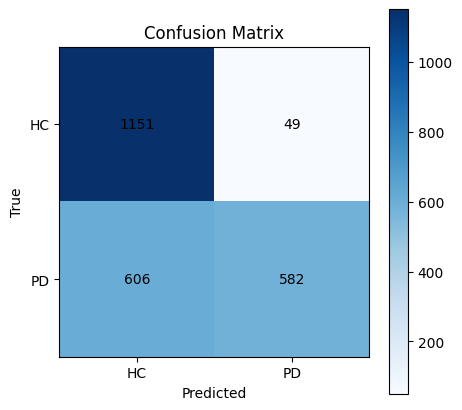

In [ ]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms, models
from PIL import Image
from sklearn.model_selection import StratifiedGroupKFold, StratifiedKFold
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt

# -------------------- CONFIG --------------------
TASK_PAIR = ["Vowels", "Words"]
CSV_PATH = "/content/drive/MyDrive/PCGITA_RESULTS/mel_metadata_augmented.csv"
MODEL_SAVE_PATH = f"/content/drive/MyDrive/PCGITA_MODELS/cnn_{'_'.join(TASK_PAIR)}.pth"

BATCH_SIZE = 32
IMG_SIZE = 224
NUM_EPOCHS = 20
NUM_CLASSES = 2
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -------------------- DATASET --------------------
class SpectrogramDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image = Image.open(row["filename"]).convert("RGB")
        label = 1 if row["label"] == "PD" else 0
        if self.transform:
            image = self.transform(image)
        return image, label

# -------------------- TRANSFORMS --------------------
transform_train = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomApply([
        transforms.ColorJitter(0.3, 0.3, 0.3),
        transforms.RandomRotation(15)
    ], p=0.7),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.RandomErasing(p=0.5),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

transform_val = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# -------------------- LOAD + FILTER DATA --------------------
df = pd.read_csv(CSV_PATH)
df = df[df["label"].isin(["PD", "HC"])]
df = df[df["task"].isin(TASK_PAIR)]

# Known vs unknown speakers split
Known = df[df["speaker_id"] != "Unknown"].copy()
Unknown = df[df["speaker_id"] == "Unknown"].copy()

# 5-fold splits
group_kfold = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)
known_splits = list(group_kfold.split(Known, Known["label"], groups=Known["speaker_id"]))
strat_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
unknown_splits = list(strat_kfold.split(Unknown, Unknown["label"]))

# Use fold 0
train_k_idx, val_k_idx = known_splits[0]
train_u_idx, val_u_idx = unknown_splits[0]

df_train = pd.concat([Known.iloc[train_k_idx], Unknown.iloc[train_u_idx]]).reset_index(drop=True)
df_val   = pd.concat([Known.iloc[val_k_idx],   Unknown.iloc[val_u_idx]]).reset_index(drop=True)

# -------------------- SAMPLER --------------------
counts = df_train['label'].value_counts()
class_weights = { 'HC': 1.0/counts['HC'], 'PD': 1.0/counts['PD'] }
weights = df_train['label'].map(class_weights).values
sampler = WeightedRandomSampler(weights, len(weights))

# -------------------- DATA LOADERS --------------------
train_dataset = SpectrogramDataset(df_train, transform=transform_train)
val_dataset   = SpectrogramDataset(df_val,   transform=transform_val)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False)

# -------------------- MODEL --------------------
model = models.resnet34(weights=models.ResNet34_Weights.DEFAULT)
# Freeze backbone initially
for param in model.parameters():
    param.requires_grad = False
# Replace head with dropout + linear
in_features = model.fc.in_features
model.fc = nn.Sequential(
    nn.Dropout(p=0.5),
    nn.Linear(in_features, NUM_CLASSES)
)
model = model.to(DEVICE)

# Unfreeze backbone after warm-up epochs if desired
UNFREEZE_AFTER = 3

# -------------------- FOCAL LOSS --------------------
alpha = torch.tensor([
    counts['PD'] / (counts['HC'] + counts['PD']),
    counts['HC'] / (counts['HC'] + counts['PD'])
], dtype=torch.float32).to(DEVICE)

class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=3.0):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.ce = nn.CrossEntropyLoss(reduction='none')

    def forward(self, inputs, targets):
        ce_loss = self.ce(inputs, targets)
        pt = torch.exp(-ce_loss)
        at = self.alpha[targets] if self.alpha is not None else 1.0
        return ((1 - pt) ** self.gamma * at * ce_loss).mean()

criterion = FocalLoss(alpha=alpha, gamma=3.0)

# -------------------- OPTIMIZER & SCHEDULER --------------------
optimizer = optim.AdamW(model.parameters(), lr=5e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=5e-4,
    steps_per_epoch=len(train_loader), epochs=NUM_EPOCHS
)

# -------------------- EARLY STOPPING --------------------
class EarlyStopping:
    def __init__(self, patience=7):
        self.patience = patience
        self.counter = 0
        self.best_loss = np.inf
        self.early_stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

early_stopper = EarlyStopping(patience=7)
best_val_acc = 0.0

# -------------------- TRAINING LOOP --------------------
for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss = 0.0

    # Unfreeze after warm-up
    if epoch == UNFREEZE_AFTER:
        for param in model.parameters():
            param.requires_grad = True

    for imgs, labels in train_loader:
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()
        running_loss += loss.item() * imgs.size(0)

    # Validation
    model.eval()
    val_loss = 0.0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * imgs.size(0)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().tolist())
            all_labels.extend(labels.cpu().tolist())

    train_loss = running_loss / len(train_loader.dataset)
    val_loss = val_loss / len(val_loader.dataset)
    val_acc = np.mean(np.array(all_preds) == np.array(all_labels))
    print(f"Epoch {epoch+1}/{NUM_EPOCHS} - "
          f"Train Loss: {train_loss:.4f} - "
          f"Val Loss: {val_loss:.4f} - Val Acc: {val_acc:.4f}")

    # Save best
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), MODEL_SAVE_PATH)
        print("✔️ Best model saved!")

    # Early stopping
    early_stopper(val_loss)
    if early_stopper.early_stop:
        print("⏹️ Early stopping triggered.")
        break

# -------------------- EVALUATION --------------------
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=["HC", "PD"]))
print(f"ROC AUC: {roc_auc_score(all_labels, all_preds):.4f}")

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(5,5))
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.colorbar()
plt.xticks([0,1], ['HC','PD'])
plt.yticks([0,1], ['HC','PD'])
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha='center', va='center')
plt.show()

# -------------------- THRESHOLD TUNING (optional) --------------------
# You can adjust the classification threshold below to improve PD recall.
# Example:
# probs = torch.softmax(model(torch.tensor(...)), dim=1)[:,1]
# preds = (probs > 0.4).long()  # use 0.4 instead of 0.5


In [ ]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms, models
from PIL import Image
from sklearn.model_selection import StratifiedGroupKFold, StratifiedKFold
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, recall_score
import matplotlib.pyplot as plt
import random

# -------------------- CONFIG --------------------
TASK_PAIR = ["Vowels", "Words"]
CSV_PATH = "/content/drive/MyDrive/PCGITA_RESULTS/mel_metadata_augmented.csv"
MODEL_DIR = "/content/drive/MyDrive/PCGITA_MODELS/ensemble"
os.makedirs(MODEL_DIR, exist_ok=True)
BATCH_SIZE = 32
IMG_SIZE = 224
NUM_EPOCHS = 20
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -------------------- HYPERPARAM GRID --------------------
param_grid = {
    'backbone': ['resnet34', 'efficientnet_b0'],
    'dropout': [0.3, 0.5],
    'lr': [1e-4, 3e-4],
    'gamma': [2.0, 3.0]
}

# -------------------- SPEC-AUGMENT --------------------
def spec_augment(img_tensor, time_mask_param=30, freq_mask_param=13):
    _, H, W = img_tensor.shape
    t = random.randrange(0, time_mask_param)
    t0 = random.randrange(0, max(1, W - t))
    img_tensor[:, :, t0:t0+t] = 0
    f = random.randrange(0, freq_mask_param)
    f0 = random.randrange(0, max(1, H - f))
    img_tensor[:, f0:f0+f, :] = 0
    return img_tensor

# -------------------- DATASET --------------------
class SpectrogramDataset(Dataset):
    def __init__(self, df, transform=None, spec_aug=False):
        self.df = df.reset_index(drop=True)
        self.transform = transform
        self.spec_aug = spec_aug
    def __len__(self): return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(row['filename']).convert('RGB')
        if self.transform: img = self.transform(img)
        if self.spec_aug: img = spec_augment(img)
        label = 1 if row['label']=='PD' else 0
        return img, label

# -------------------- TRANSFORMS --------------------
base_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])
aug_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ColorJitter(0.4,0.4,0.4),
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.RandomErasing(p=0.7),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# -------------------- LOAD DATA & SPLIT --------------------
df = pd.read_csv(CSV_PATH)
df = df[df['label'].isin(['PD','HC']) & df['task'].isin(TASK_PAIR)]
Known, Unknown = df[df['speaker_id']!='Unknown'], df[df['speaker_id']=='Unknown']
kg = StratifiedGroupKFold(5, shuffle=True, random_state=42)
ug = StratifiedKFold(5, shuffle=True, random_state=42)
ks, us = list(kg.split(Known, Known['label'], groups=Known['speaker_id'])), list(ug.split(Unknown, Unknown['label']))
train_k, val_k = ks[0]; train_u, val_u = us[0]
df_train = pd.concat([Known.iloc[train_k], Unknown.iloc[train_u]]).reset_index(drop=True)
df_val = pd.concat([Known.iloc[val_k], Unknown.iloc[val_u]]).reset_index(drop=True)

# -------------------- SAMPLER --------------------
counts = df_train['label'].value_counts()
w = { 'HC':1/counts['HC'], 'PD':1/counts['PD'] }
weights = df_train['label'].map(w).values
sampler = WeightedRandomSampler(weights, len(weights))

# -------------------- MODEL BUILDER --------------------
def build_model(name, dropout):
    if name=='resnet34':
        m = models.resnet34(weights=models.ResNet34_Weights.DEFAULT)
        in_feat = m.fc.in_features
    else:
        m = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)
        in_feat = m.classifier[-1].in_features
    head = nn.Sequential(nn.Dropout(dropout), nn.Linear(in_feat, 2))
    if name=='resnet34': m.fc = head
    else: m.classifier = head
    return m.to(DEVICE)

# -------------------- TRAIN & EVALUATE --------------------
def train_eval(params, model_id):
    bb, dr, lr, gm = params.values()
    model = build_model(bb, dr)
    alpha = torch.tensor([counts['PD']/(counts.sum()), counts['HC']/(counts.sum())]).to(DEVICE)
    criterion = FocalLoss(alpha=alpha, gamma=gm)
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)

    dl_train = DataLoader(SpectrogramDataset(df_train, aug_transforms, spec_aug=True),
                          batch_size=BATCH_SIZE, sampler=sampler)
    dl_val = DataLoader(SpectrogramDataset(df_val, base_transforms), batch_size=BATCH_SIZE)

    best_acc = 0; stopper = EarlyStopping(patience=7)
    for epoch in range(NUM_EPOCHS):
        model.train(); tloss=0
        for x,y in dl_train:
            x,y = x.to(DEVICE), y.to(DEVICE)
            optimizer.zero_grad(); out=model(x); loss=criterion(out,y)
            loss.backward(); optimizer.step(); tloss+=loss.item()*x.size(0)
        scheduler.step()
        model.eval(); preds, labs = [], []
        with torch.no_grad():
            for x,y in dl_val:
                x,y = x.to(DEVICE), y.to(DEVICE)
                out = model(x); preds+=torch.argmax(out,1).cpu().tolist(); labs+=y.cpu().tolist()
        acc = np.mean(np.array(preds)==np.array(labs))
        pd_rec = recall_score(labs, preds, pos_label=1)
        hc_rec = recall_score(labs, preds, pos_label=0)
        roc = roc_auc_score(labs, preds)
        if acc>best_acc:
            best_acc=acc; torch.save(model.state_dict(), f"{MODEL_DIR}/{model_id}.pth")
        stopper(1-acc)
        if stopper.early_stop: break
    return {**params, 'val_acc':best_acc, 'pd_recall':pd_rec, 'hc_recall':hc_rec, 'roc_auc':roc}

# -------------------- GRID SEARCH --------------------
results = []
tasks = [dict(zip(param_grid, vals)) for vals in
         [(bb,dr,lr,gm) for bb in param_grid['backbone']
                          for dr in param_grid['dropout']
                          for lr in param_grid['lr']
                          for gm in param_grid['gamma']]]
for i, p in enumerate(tasks):
    res = train_eval(p, f"model_{i}"); results.append(res)

# -------------------- RESULTS VISUALIZATION --------------------
df_res = pd.DataFrame(results).sort_values('pd_recall', ascending=False)
print(df_res[['backbone','dropout','lr','gamma','val_acc','pd_recall','hc_recall','roc_auc']])

# Plot PD Recall and ROC AUC for each model
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.bar(range(len(df_res)), df_res['pd_recall']); plt.title('PD Recall'); plt.xticks(range(len(df_res)), df_res.index, rotation=90)
plt.subplot(1,2,2)
plt.bar(range(len(df_res)), df_res['roc_auc']); plt.title('ROC AUC'); plt.xticks(range(len(df_res)), df_res.index, rotation=90)
plt.tight_layout(); plt.show()

# -------------------- ENSEMBLE --------------------
top = df_res.head(2)
paths = [f"{MODEL_DIR}/model_{idx}.pth" for idx in top.index]

def ensemble_predict(paths):
    models_ = []
    for path in paths:
        bb = 'efficientnet_b0' if 'efficientnet' in path else 'resnet34'
        m = build_model(bb, dropout=0.5)
        m.load_state_dict(torch.load(path)); m.eval(); models_.append(m)
    preds, labs = [], []
    dl = DataLoader(SpectrogramDataset(df_val, base_transforms), batch_size=BATCH_SIZE)
    with torch.no_grad():
        for x,y in dl:
            x = x.to(DEVICE)
            avg = sum(torch.softmax(m(x),1) for m in models_) / len(models_)
            p = torch.argmax(avg,1).cpu().tolist()
            preds+=p; labs+=y.tolist()
    print(classification_report(labs, preds, target_names=['HC','PD']))
    print('Ensemble ROC AUC:', roc_auc_score(labs, preds))
    cm = confusion_matrix(labs, preds)
    plt.imshow(cm, cmap='Blues'); plt.title('Ensemble CM'); plt.colorbar();
    plt.xticks([0,1],['HC','PD']); plt.yticks([0,1],['HC','PD'])
    for i in range(2):
        for j in range(2): plt.text(j,i,cm[i,j],ha='center')
    plt.show()

ensemble_predict(paths)


In [ ]:
# -------------------- SETUP --------------------
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# === CONFIG ===
CSV_PATH = "/content/drive/MyDrive/PCGITA_RESULTS/logspec_metadata_augmented.csv"
BATCH_SIZE = 32
IMG_SIZE = 224
NUM_EPOCHS = 20
NUM_CLASSES = 2
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -------------------- DATASET --------------------
class LogSpecDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image = Image.open(row["filename"]).convert("RGB")
        label = 1 if row["label"] == "PD" else 0

        if self.transform:
            image = self.transform(image)

        return image, label

# -------------------- TRANSFORMS --------------------
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# -------------------- DATA SPLIT --------------------
df = pd.read_csv(CSV_PATH)
df = df[df["label"].isin(["PD", "HC"])]

group_kfold = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)
splits = list(group_kfold.split(df, df["label"], groups=df["speaker_id"]))
train_idx, val_idx = splits[0]
df_train = df.iloc[train_idx]
df_val = df.iloc[val_idx]

train_dataset = LogSpecDataset(df_train, transform=transform)
val_dataset = LogSpecDataset(df_val, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# -------------------- MODEL --------------------
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES)
model = model.to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# -------------------- TRAIN LOOP --------------------
train_losses, val_losses = [], []
best_val_acc = 0

for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss = 0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} - Training"):
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_losses.append(running_loss / len(train_loader))

    model.eval()
    val_loss = 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc="Validation"):
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    val_losses.append(val_loss / len(val_loader))

    acc = np.mean(np.array(all_preds) == np.array(all_labels))
    print(f"Epoch {epoch+1}: Val Acc: {acc:.4f}")

    if acc > best_val_acc:
        best_val_acc = acc
        torch.save(model.state_dict(), "/content/drive/MyDrive/PCGITA_MODELS/best_cnn_logspec.pth")
        print("✅ Best model saved!")

# -------------------- EVALUATION --------------------
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=["HC", "PD"]))

auc = roc_auc_score(all_labels, all_preds)
print(f"ROC AUC: {auc:.4f}")

cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["HC", "PD"], yticklabels=["HC", "PD"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [ ]:
# -------------------- LIGHTWEIGHT CNN TRAINING ON LOG-SPECTROGRAMS --------------------
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# === CONFIG ===
CSV_PATH = "/content/drive/MyDrive/PCGITA_RESULTS/logspec_metadata_augmented.csv"
BATCH_SIZE = 32
IMG_SIZE = 224
NUM_EPOCHS = 10  # Short training for speed
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_CLASSES = 2
SUBSET_SIZE = 1000

# === DATASET CLASS ===
class SpectrogramDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image = Image.open(row["filename"]).convert("RGB")
        label = 1 if row["label"] == "PD" else 0

        if self.transform:
            image = self.transform(image)

        return image, label

# === TRANSFORMS ===
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# === LOAD CSV AND SAMPLE ===
df = pd.read_csv(CSV_PATH)
df = df[df["label"].isin(["PD", "HC"])]
df = df.sample(n=SUBSET_SIZE, random_state=42)

# === TRAIN-VAL SPLIT ===
group_kfold = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)
splits = list(group_kfold.split(df, df["label"], groups=df["speaker_id"]))
train_idx, val_idx = splits[0]
df_train = df.iloc[train_idx]
df_val = df.iloc[val_idx]

train_dataset = SpectrogramDataset(df_train, transform=transform)
val_dataset = SpectrogramDataset(df_val, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# === MODEL ===
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES)
model = model.to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# === TRAINING LOOP ===
best_val_acc = 0
train_losses, val_losses = [], []

for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss = 0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} - Training"):
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_losses.append(running_loss / len(train_loader))

    # Validation
    model.eval()
    val_loss = 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    val_losses.append(val_loss / len(val_loader))
    acc = np.mean(np.array(all_preds) == np.array(all_labels))

    print(f"Epoch {epoch+1}: Val Acc: {acc:.4f}")

    if acc > best_val_acc:
        best_val_acc = acc
        torch.save(model.state_dict(), "/content/drive/MyDrive/PCGITA_MODELS/best_cnn_logspec_subset.pth")
        print("✅ Best model saved!")

# === EVALUATION ===
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=["HC", "PD"]))

auc = roc_auc_score(all_labels, all_preds)
print(f"ROC AUC: {auc:.4f}")

cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["HC", "PD"], yticklabels=["HC", "PD"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()
